In [1]:
REPOSITORY_PATH = 'BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation'
DATA_PATH = 'data'

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from skimage.util import view_as_blocks, view_as_windows

from core.utility import preprocess_input, estimation_by_mse, image_by_qf_generator, read_and_preprocess_image, double_compress_image, compress_image
from core.model import Model

np.random.seed(322)

map_90 - [(60, 90), (98, 90)]

map_80 - [(50, 80), (98, 80)]

In [3]:
modelname = 'model_QF1_60-98_QF2_90-2-term-loss.h5'
qf_map_name = 'qf1_qf2_map_90.npy'
model_path = os.path.join(REPOSITORY_PATH, 'models', modelname)
qf_map_path = os.path.join(REPOSITORY_PATH, 'resources', qf_map_name)

In [4]:
model = Model(model_path, qf_map_path)

Построить график зависимости ошибки при оценивании 𝑄𝐹1 в зависимости от числа
патчей 𝑝. Дойти до такого значения 𝑝, при котором график стабилизируется.

In [5]:
def predict(image):
    image = preprocess_input(image, (64, 64))
    preds = model.estimate_qf1(image, lambda x, y: estimation_by_mse(x, y, weights=None, used_coeffs=slice(16)))
    return preds

In [6]:
test_cases = [
    (70, ),
    (85, 90),
    (60, 90),
    (95, 90),
    (89, 90)
]
# Assume that 30 patches will be enough
MAX_PATCHES = 30

path_to_table = os.path.join(DATA_PATH, 'pathces_exp_results.csv')
path_to_images = os.path.join(DATA_PATH, '*.tif')
target_size = (64, 64)

if not os.path.exists(path_to_table):
    experiment_results = []
    for test_case in tqdm(test_cases, position=0):
        for filename in tqdm(glob(path_to_images), position=1, leave=True):
            image = cv2.imread(filename)
            all_blocks = view_as_windows(image, (64, 64, 3), step=64).reshape(-1, 64, 64, 3)
            np.random.shuffle(all_blocks)
            image_blocks = all_blocks[:MAX_PATCHES]
            for block_idx, image_block in enumerate(image_blocks):
                if len(test_case) == 1:
                    compressed_img = compress_image(image_block, *test_case)
                else:
                    compressed_img = double_compress_image(image_block, *test_case)
                qf1_qf2_hat = predict(compressed_img)
                error = np.abs(qf1_qf2_hat[0] - test_case[0])
                experiment_results.append([filename, block_idx, test_case, qf1_qf2_hat, error])
    
    df = pd.DataFrame(experiment_results, columns=['filename', 'blockidx', 'test_case', 'prediction', 'error'])
    df.to_csv(path_to_table)

In [7]:
df = pd.read_csv(path_to_table)
df

,Unnamed: 0,filename,blockidx,test_case,prediction,error
0,0,data/0.tif,0,"(70,)",[71 90],1
1,1,data/0.tif,1,"(70,)",[68 90],2
2,2,data/0.tif,2,"(70,)",[67 90],3
3,3,data/0.tif,3,"(70,)",[63 90],7
4,4,data/0.tif,4,"(70,)",[69 90],1
...,...,...,...,...,...,...
1495,1495,data/9.tif,25,"(89, 90)",[93 90],4
1496,1496,data/9.tif,26,"(89, 90)",[94 90],5
1497,1497,data/9.tif,27,"(89, 90)",[91 90],2
1498,1498,data/9.tif,28,"(89, 90)",[89 90],0


In [8]:
means_per_number_of_blocks = []
for i in range(MAX_PATCHES):
    means_per_number_of_blocks.append(
        df.query(f'blockidx <= {i}')\
            .groupby(['test_case'])\
            ['error']\
            .mean()\
            .to_dict()
    )

In [9]:
to_plot_data = {k: [] for k in means_per_number_of_blocks[0].keys()}
for r in means_per_number_of_blocks:
    for key, value in r.items():
        to_plot_data[key].append(value)

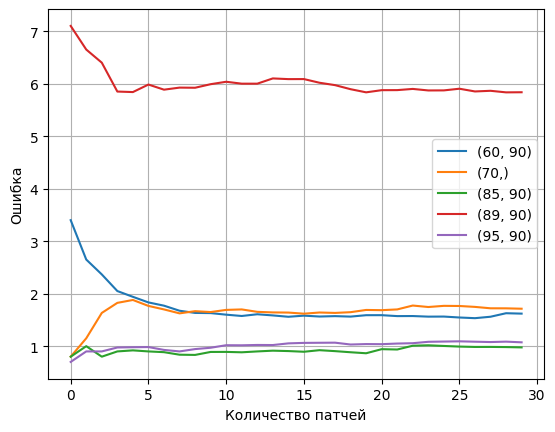

In [19]:
for whom, values in to_plot_data.items():
    plt.plot(np.arange(len(values)), values, label=f'{whom}')
plt.xlabel("Количество патчей")
plt.ylabel("Ошибка")
plt.legend()
plt.grid()
plt.show()

In [18]:
df.groupby(['test_case'])\
            ['error']\
            .mean()\
            .to_frame()

,error
test_case,
"(60, 90)",1.620000
"(70,)",1.713333
"(85, 90)",0.976667
"(89, 90)",5.836667
"(95, 90)",1.073333
